# Optimal tariff analysis
Project Description

You are an analyst at Megaline, a federal mobile operator. Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.
You have to make a preliminary analysis of tariffs on a small sample of customers. At your disposal are the data of 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and draw a conclusion - which tariff is better.

Tariff Description

Tariff "Smart"
Monthly fee: 550 rubles
Included 500 minutes of talk, 50 messages and 15 GB of internet traffic
The cost of services in excess of the tariff package: 1. minute of conversation: 3 rubles ("Megaline" always rounds up the values ​​of minutes and megabytes. If the user spoke only 1 second, a whole minute is counted in the tariff); 2. message: 3 rubles; 3. 1 GB of Internet traffic: 200 rubles.

Tariff "Ultra"
Monthly fee: 1950 rubles
Included 3000 minutes of calls, 1000 messages and 30 GB of internet traffic
Cost of services in excess of the tariff package: 1. minute of conversation: 1 ruble; 2. message: 1 ruble; 3. 1 GB of Internet traffic: 150 rubles.

Note:
Megaline always rounds seconds to minutes, and megabytes to gigabytes. Each call is rounded up separately: even if it lasted only 1 second, it will be counted as 1 minute.
For web traffic, individual sessions are not counted. Instead, the monthly total is rounded up. If a subscriber uses 1025 megabytes this month, they will be charged for 2 gigabytes.

Calculate for each user:
the number of calls made and spent minutes of conversation by month;
number of sent messages by month;
the amount of Internet traffic used by months;
monthly revenue from each user (subtract the free limit from the total number of calls, messages and Internet traffic; multiply the remainder by the value from the tariff plan; add the subscription fee corresponding to the tariff plan).

Describe the behavior of the operator's customers based on the sample. How many minutes of conversation, how many messages and how much Internet traffic do users of each tariff need per month? Calculate the mean, variance and standard deviation. Plot histograms. Describe the distributions.

Test Hypotheses- the average revenue of users of the "Ultra" and "Smart" tariffs differ;
the average revenue of users from Moscow differs from the revenue of users from other regions.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import math
import numpy as np
import scipy

In [2]:
calls=pd.read_csv('calls.csv')
internet=pd.read_csv('internet.csv')
messages=pd.read_csv('messages.csv')
tariffs=pd.read_csv('tariffs.csv')
users=pd.read_csv('users.csv')

# Data preprocessing

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
#changing the type of column
calls['call_date']=pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
#rounding to ceiling and changing type to integer
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls['id'] = calls['id'].astype('int')

In [6]:
internet.head()


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
#changing the type of column
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['id'] = internet['id'].astype('int')
#deletting unnamed column
del internet['Unnamed: 0']

In [9]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
#changing the type of column
messages['message_date']=pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['id'] = messages['id'].astype('int')

In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [14]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
#changing the type of column
users['reg_date']=pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date']=pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# 1st Task
Calculate for each user: the number of calls made and spent minutes of conversation by month; number of sent messages by month; the amount of Internet traffic used by months; monthly revenue from each user (subtract the free limit from the total number of calls, messages and Internet traffic; multiply the remainder by the value from the tariff plan; add the subscription fee corresponding to the tariff plan).


In [17]:
# the number of calls made and spent minutes of conversation by month
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [18]:
calls['month']=calls['call_date'].dt.month

In [19]:
user_calls=calls.groupby(['user_id','month']).agg({'duration':['count', 'sum']})
user_calls.columns=['num_of_calls','total_duration']
user_calls.head()

num_of_calls  total_duration
user_id month                              
1000    5                22             159
        6                43             172
        7                47             340
        8                52             408
        9                58             466

In [20]:
#number of sent messages by month
messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


In [21]:
messages['month']=messages['message_date'].dt.month

In [22]:
user_messages=messages.groupby(['user_id','month']).agg({'message_date':['count']}) 
user_messages.columns=['num_of_mes']
user_messages.head(20)

num_of_mes
user_id month            
1000    5              22
        6              60
        7              75
        8              81
        9              57
        10             73
        11             58
        12             70
1002    6               4
        7              11
        8              13
        9               4
        10             10
        11             16
        12             12
1003    8              37
        9              91
        10             83
        11             94
        12             75

In [23]:
#the amount of Internet traffic used by months
internet.head()

,id,mb_used,session_date,user_id
0,10000,112.95,2018-11-25,1000
1,10001,1052.81,2018-09-07,1000
2,10002,1197.26,2018-06-25,1000
3,10003,550.27,2018-08-22,1000
4,10004,302.56,2018-09-24,1000


In [24]:
internet['month']=internet['session_date'].dt.month

In [25]:
user_internet=internet.groupby(['user_id','month']).agg({'mb_used':['sum']}) 
user_internet.columns=['monthly_traffic']
user_internet.head()

monthly_traffic
user_id month                 
1000    5              2253.49
        6             23233.77
        7             14003.64
        8             14055.93
        9             14568.91

In [26]:
#monthly revenue from each user
data=user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')


In [27]:
data.head()

num_of_calls  total_duration  num_of_mes
user_id month                                          
1000    5              22.0           159.0        22.0
        6              43.0           172.0        60.0
        7              47.0           340.0        75.0
        8              52.0           408.0        81.0
        9              58.0           466.0        57.0

In [28]:
data=data.merge(user_internet, on=['user_id', 'month'], how='outer' )

In [29]:
data.head()

num_of_calls  total_duration  num_of_mes  monthly_traffic
user_id month                                                           
1000    5              22.0           159.0        22.0          2253.49
        6              43.0           172.0        60.0         23233.77
        7              47.0           340.0        75.0         14003.64
        8              52.0           408.0        81.0         14055.93
        9              58.0           466.0        57.0         14568.91

In [30]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [31]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [32]:
data.reset_index(inplace=True)

In [33]:
data.head()

,user_id,month,num_of_calls,total_duration,num_of_mes,monthly_traffic
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91


In [34]:
data=data.merge(users, on='user_id', how='left')

In [35]:
data.head()

,user_id,month,num_of_calls,total_duration,num_of_mes,monthly_traffic,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [36]:
tariffs.columns.tolist()

['messages_included',
 'mb_per_month_included',
 'minutes_included',
 'rub_monthly_fee',
 'rub_per_gb',
 'rub_per_message',
 'rub_per_minute',
 'tariff_name']

In [37]:
tariffs.columns=['messages_included',
 'mb_per_month_included',
 'minutes_included',
 'rub_monthly_fee',
 'rub_per_gb',
 'rub_per_message',
 'rub_per_minute',
 'tariff']

In [38]:
data=data.merge(tariffs, on='tariff', how='left')

In [39]:
data.head()

,user_id,month,num_of_calls,total_duration,num_of_mes,monthly_traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [40]:
data.isna().sum()

user_id                     0
month                       0
num_of_calls               40
total_duration             40
num_of_mes                497
monthly_traffic            11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [41]:
data['num_of_calls']=data['num_of_calls'].fillna(0)
data['total_duration']=data['total_duration'].fillna(0)
data['num_of_mes']=data['num_of_mes'].fillna(0)
data['monthly_traffic']=data['monthly_traffic'].fillna(0)

In [42]:
data.isna().sum()

user_id                     0
month                       0
num_of_calls                0
total_duration              0
num_of_mes                  0
monthly_traffic             0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [43]:
data.head()

,user_id,month,num_of_calls,total_duration,num_of_mes,monthly_traffic,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [44]:
#data['messages_above']=data['num_of_mes']-data['messages_included']

In [45]:
def messages_above(row):
    messages=row['num_of_mes']-row['messages_included']
    if messages<=0:
        return 0
    else: 
        return messages

In [46]:
data['messages_above']=data.apply(messages_above, axis=1)

In [47]:
def mb_above(row):
    mb=row['monthly_traffic']-row['mb_per_month_included']
    if mb<=0:
        return 0
    else: 
        return mb

In [48]:
data['mb_above']=data.apply(mb_above, axis=1)

In [49]:
def minutes_above(row):
    minutes=row['total_duration']-row['minutes_included']
    if minutes<=0:
        return 0
    else: 
        return minutes

In [50]:
data['minutes_above']=data.apply(minutes_above, axis=1)

In [51]:
data.head()

,user_id,month,num_of_calls,total_duration,num_of_mes,monthly_traffic,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,messages_above,mb_above,minutes_above
0,1000,5,22.0,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,6,43.0,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,7,47.0,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,8,52.0,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,9,58.0,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0


In [52]:
data['revenue']=data['rub_monthly_fee']+data['messages_above']*data['rub_per_message']+data['minutes_above']*data['rub_per_minute']+np.ceil(data['mb_above']/1024)*data['rub_per_gb']


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   num_of_calls           3214 non-null   float64       
 3   total_duration         3214 non-null   float64       
 4   num_of_mes             3214 non-null   float64       
 5   monthly_traffic        3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

## 2nd Task
Describe the behavior of the operator's customers based on the sample. How many minutes of conversation, how many messages and how much Internet traffic do users of each tariff need per month? Calculate the mean, variance and standard deviation. Plot histograms. Describe the distributions.

In [54]:
data.groupby('tariff').agg({'total_duration':['mean', 'var' , 'std']})

total_duration                           
                 mean            var         std
tariff                                          
smart      417.934948   36219.315784  190.313730
ultra      526.623350  100873.633397  317.606098

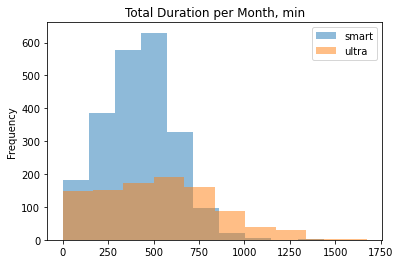

In [55]:
data[data['tariff']=="smart"]['total_duration'].plot(kind='hist',bins=10, title='Total Duration per Month, min', label='smart', legend=1,alpha=0.5)
data[data['tariff']=="ultra"]['total_duration'].plot(kind='hist',bins=10, label='ultra', legend=1, alpha=0.5)
plt.show()

In [56]:
data.groupby('tariff').agg({'num_of_mes':['mean', 'var' , 'std']})

num_of_mes                        
             mean          var        std
tariff                                   
smart   33.384029   796.812958  28.227876
ultra   49.363452  2285.266143  47.804457

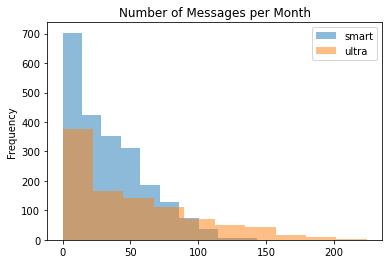

In [57]:
data[data['tariff']=="smart"]['num_of_mes'].plot(kind='hist',bins=10, title='Number of Messages per Month', label='smart', legend=1,alpha=0.5)
data[data['tariff']=="ultra"]['num_of_mes'].plot(kind='hist',bins=10, label='ultra', legend=1, alpha=0.5)
plt.show()

In [58]:
data.groupby('tariff').agg({'monthly_traffic':['mean', 'var' , 'std']})

monthly_traffic                            
                  mean           var           std
tariff                                            
smart     16208.386990  3.446250e+07   5870.476681
ultra     19468.805208  1.017510e+08  10087.170752

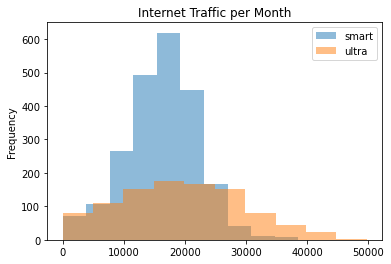

In [59]:
data[data['tariff']=="smart"]['monthly_traffic'].plot(kind='hist',bins=10, title='Internet Traffic per Month', label='smart', legend=1,alpha=0.5)
data[data['tariff']=="ultra"]['monthly_traffic'].plot(kind='hist',bins=10, label='ultra', legend=1, alpha=0.5)
plt.show()

## 3rd Task
Test Hypotheses- the average revenue of users of the "Ultra" and "Smart" tariffs differ;
the average revenue of users from Moscow differs from the revenue of users from other regions.

In [60]:
len(data)

3214

In [61]:
#deleting outliers using IQR method
def delete_outliers(df, column):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    return df.loc[iqr_test]

In [62]:
smart=data.query('tariff=="smart"')
ultra=data.query('tariff=="ultra"')

In [63]:
smart=delete_outliers(smart,'revenue')
ultra=delete_outliers(ultra, 'revenue')

In [64]:
smart=smart['revenue']
ultra=ultra['revenue']

In [71]:
# checking the average revenue of users of the "Ultra" and "Smart" tariffs differ
# H0: revenue doesn't differ
# H1: revenue differs
alpha=0.05
results=st.ttest_ind(smart,ultra)
print('P-value:', results.pvalue)
if results.pvalue<alpha:
    print('null hyphothesis is wrong, revenue differs')
else:
    print('null hyphothesis is not wrong, revenue doesnt differ')

P-value: 6.199325734910118e-155
null hyphothesis is wrong, revenue differs


In [70]:
#the average revenue of users from Moscow differs from the revenue of users from other regions
moscow=data.query('city=="Москва"')
province=data.query('city!="Москва"')

In [67]:
moscow=delete_outliers(moscow,'revenue')
province=delete_outliers(province, 'revenue')

In [68]:
moscow=moscow['revenue']
province=province['revenue']

In [69]:
# H0: revenue doesn't differ
# H1: revenue differs
alpha=0.05
results2=st.ttest_ind(moscow,province)
print('P-value:', results2.pvalue)
if results2.pvalue<alpha:
    print('null hyphothesis is wrong, revenue differs')
else:
    print('null hyphothesis is not wrong, revenue doesnt differ')

P-value: 0.29404256281786195
null hyphothesis is not wrong
